# Sport instalation analysis

Variables:
- age	Age of the participants in years
- sex	Sex (0-female, 1-male)
- dayswfreq	Non-attendance days before dropout
- tbilled	Total amount billed in euros during the registration period (values in euros). 
- maccess	Average number of visits per week
- freeuse	Free use (0-no, 1-yes)
- nentries	Total number of visits to the fitness center that the customer made during the registration 
- cfreq	Weekly contracted accesses 
- nrenewals	Number of registration renewals
- cref	Number of customer referrals
- rmonth	Registration month
- months	Customer enrolment (total time in months)
- dropout	Measure of customers’ commitment (0=active, 1=dropout)


1/TRUE = dead i.e. abandonou
0/FALSE = alive i.e. não abandonou


Corrections to the analysis considering the reviewers suggestions:
1. Include 95% confidence intervals in Table 2 for the AUC
2. Before moving to decision tree models, one should always try standard logistic regression
3. There needs to be some cross validation performed. The reviewer suggests performing a three-fold cross validation for at least 50 iterations. This will generate condence intervals that the authors can see how stable their models are
4. Data stratification on the hold-out

# Support functions

In [1]:
# Adapted from https://gist.github.com/doraneko94/e24643136cfb8baf03ef8a314ab9615c
from sklearn.metrics import roc_auc_score
from math import sqrt
def roc_auc_ci(y_true, y_score, positive=1):
    '''
    # y_true = TRUE data
    # y_pred = predicted data at the model
    '''
    auc = roc_auc_score(y_true, y_score)
    n1 = sum(y_true == positive)
    n2 = sum(y_true != positive)
    q1 = auc / (2 - auc)
    q2 = 2*auc**2 / (1 + auc)
    se_auc = sqrt((auc*(1 - auc) + (n1 - 1)*(q1 - auc**2) + (n2 - 1)*(q2 - auc**2)) / (n1*n2))
    lower = auc - 1.96*se_auc
    upper = auc + 1.96*se_auc
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# Imports

In [2]:
import numpy as np
import pandas as pd
import time
from sklearn import linear_model, datasets
from sklearn import metrics
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
import time

import graphviz
import pydotplus
#import pydot
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn import metrics
import time

import graphviz
import pydotplus
#import pydot
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn import tree
from dtreeviz.trees import *

In [9]:
%matplotlib inline

# Data processing

In [10]:
#reading data
dt = pd.read_excel('dataset/fitnessCustomers.xlsx',index_col=0)

In [11]:
#rows and columns
dt.shape

(5216, 13)

In [12]:
#feature names
dt.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'freeuse', 'nentries',
       'cfreq', 'nrenewals', 'cref', 'startDate', 'months', 'dropout'],
      dtype='object')

In [13]:
dt.head(2).T

Id,00130FE8-5D34-4C66-9819-1EB0BFE69979,0016D0DD-E713-4EDC-BAA3-386AB4CE6779
age,23,34
sex,1,1
dayswfreq,7,328
tbilled,37.6,205.6
maccess,1.35,0.54
freeuse,0,0
nentries,6,39
cfreq,7,7
nrenewals,0,2
cref,0,0


In [14]:
# number Customers by dropout
dt.dropout.value_counts()

1    4566
0     650
Name: dropout, dtype: int64

In [15]:
dt.head().T

Id,00130FE8-5D34-4C66-9819-1EB0BFE69979,0016D0DD-E713-4EDC-BAA3-386AB4CE6779,001A70CA-0985-42D1-A0C0-6D70BEC00BFB,001B9AC2-7711-4384-BF9D-C5205F68BDFC,001D927E-ACD2-4B3D-ACDA-1480F6A31F3E
age,23,34,24,20,21
sex,1,1,0,1,1
dayswfreq,7,328,3,41,18
tbilled,37.6,205.6,140,71.6,113.2
maccess,1.35,0.54,0.8,1,0.08
freeuse,0,0,0,0,0
nentries,6,39,28,13,7
cfreq,7,7,7,7,7
nrenewals,0,2,0,0,3
cref,0,0,0,0,0


## Inscription month calculation

In [16]:
# Calculate inscriptio month
dt['rmonth']=dt['startDate'].str.extract('-(\d\d)', expand=True)
dt['rmonth']=pd.to_numeric(dt['rmonth'])

In [17]:
# drop start date
dt.drop(axis=1,columns=['startDate'],inplace=True)

In [18]:
dt.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'freeuse', 'nentries',
       'cfreq', 'nrenewals', 'cref', 'months', 'dropout', 'rmonth'],
      dtype='object')

In [19]:
dt.head(2).T

Id,00130FE8-5D34-4C66-9819-1EB0BFE69979,0016D0DD-E713-4EDC-BAA3-386AB4CE6779
age,23.00,34.00
sex,1.00,1.00
dayswfreq,7.00,328.00
tbilled,37.60,205.60
maccess,1.35,0.54
freeuse,0.00,0.00
nentries,6.00,39.00
cfreq,7.00,7.00
nrenewals,0.00,2.00
cref,0.00,0.00


## Checking null values

In [20]:
dt.isnull().any()

age          False
sex          False
dayswfreq    False
tbilled      False
maccess      False
freeuse      False
nentries     False
cfreq         True
nrenewals    False
cref         False
months       False
dropout      False
rmonth       False
dtype: bool

In [21]:
dt.cfreq.value_counts()

7.0    5008
4.0     125
2.0      67
6.0      10
Name: cfreq, dtype: int64

In [22]:
# where are the nulls?
dt[pd.isnull(dt['cfreq'])]

,age,sex,dayswfreq,tbilled,maccess,freeuse,nentries,cfreq,nrenewals,cref,months,dropout,rmonth
Id,,,,,,,,,,,,,
4CA4608D-9366-46C7-9B51-7916E516B691,26,0,22,58.6,0.70,0,3,NaN,0,0,1,0,10
649D78E8-4C98-4397-AEDF-C6959AD959EA,26,0,6,126.1,0.03,0,3,NaN,2,0,25,0,10
6ABEE4C8-951A-4FE1-BF90-AAD1875AD582,21,0,8,58.6,1.63,0,7,NaN,0,0,1,0,10
A7438DA1-1801-4E73-8B99-896CC347C8FC,18,0,5,58.6,3.25,0,13,NaN,0,0,1,0,10
AEEDCE35-83DC-4CCB-A81F-5912FB6FE5C6,20,0,4,58.6,3.03,0,13,NaN,0,0,1,0,10
DE419BDD-A882-4754-8AA5-6656AF1D37CE,20,1,1,106.1,3.67,0,22,NaN,0,0,2,0,9


In [23]:
# How many values are nulls?
dt['cfreq'][pd.isnull(dt['cfreq'])].shape

(6,)

In [24]:
dt.shape

(5216, 13)

In [25]:
dt.dropna(axis=0,inplace=True)

In [26]:
dt.shape

(5210, 13)

### Drop freeuse column
The software used is also used to manage other sport facilities, such as swimming pools. In this study e only used customers that only perform fitness activities.The free use represents customers that in the past performed free use, which means that used to develop free swimming without a coach supervising their activity. That variable shouldn’t be in the study, and therefore we removed it.

In [27]:
dt.drop(axis=1,columns=['freeuse'],inplace=True)

## Descriptives

In [28]:
dt.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5210.0,27.881766,11.804636,0.00,21.0000,23.00,30.00,93.00
sex,5210.0,0.351823,0.477585,0.00,0.0000,0.00,1.00,1.00
dayswfreq,5210.0,76.406526,101.792781,0.00,10.0000,41.00,99.00,991.00
tbilled,5210.0,155.314637,162.435028,3.60,61.6000,102.60,186.10,3747.20
maccess,5210.0,0.890616,0.761275,0.01,0.3325,0.68,1.21,10.33
nentries,5210.0,29.062188,41.149181,1.00,6.0000,15.00,34.75,585.00
cfreq,5210.0,6.861804,0.721352,2.00,7.0000,7.00,7.00,7.00
nrenewals,5210.0,0.777351,0.900260,0.00,0.0000,1.00,1.00,4.00
cref,5210.0,0.005566,0.076943,0.00,0.0000,0.00,0.00,2.00
months,5210.0,9.350288,8.215163,0.00,3.0000,7.00,12.00,47.00


### Checking Min age = 0
There is something not well, minimum age of 0

In [29]:
dt.loc[dt.age<10].T

Id,352A9804-29B4-49CA-BDF1-EEC6453F38D5,5AE0C2F9-35F0-4EB4-AE2F-F7398E3C75BF
age,9.00,0.0
sex,0.00,0.0
dayswfreq,204.00,118.0
tbilled,229.40,121.1
maccess,0.34,0.9
nentries,14.00,23.0
cfreq,4.00,7.0
nrenewals,1.00,1.0
cref,0.00,0.0
months,10.00,7.0


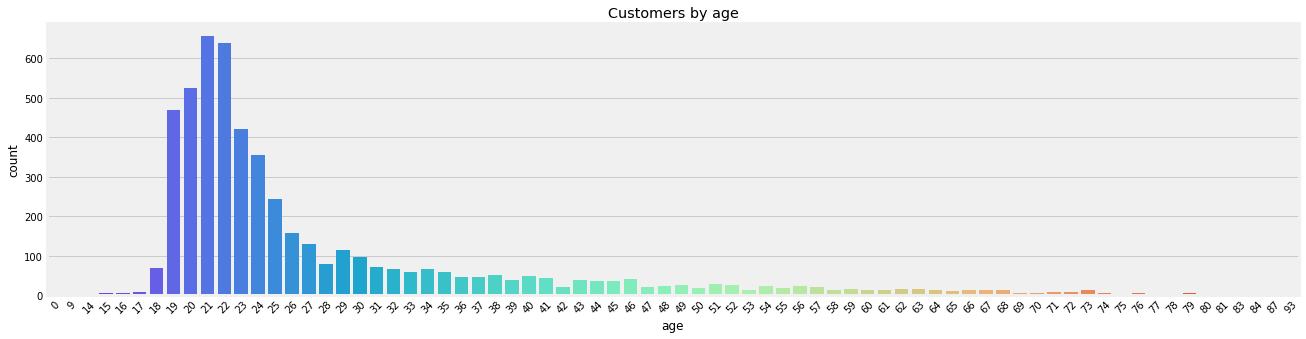

In [30]:
plt.rcParams['figure.figsize'] = [20, 5]
sns.countplot(x='age',data=dt,palette='rainbow').set_title('Customers by age')
plt.xticks(rotation=45);

### Remove the customer with age = 0

In [31]:
dt=dt.loc[dt.age!=0]

In [32]:
dt['sex'].value_counts()

0    3376
1    1833
Name: sex, dtype: int64

### Final descriptives

In [33]:
dt.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5209.0,27.887118,11.799444,9.00,21.00,23.00,30.00,93.00
sex,5209.0,0.351891,0.477606,0.00,0.00,0.00,1.00,1.00
dayswfreq,5209.0,76.398541,101.800921,0.00,10.00,41.00,99.00,991.00
tbilled,5209.0,155.321206,162.449930,3.60,61.60,102.60,186.10,3747.20
maccess,5209.0,0.890614,0.761348,0.01,0.33,0.68,1.21,10.33
nentries,5209.0,29.063352,41.153046,1.00,6.00,15.00,35.00,585.00
cfreq,5209.0,6.861778,0.721419,2.00,7.00,7.00,7.00,7.00
nrenewals,5209.0,0.777309,0.900341,0.00,0.00,1.00,1.00,4.00
cref,5209.0,0.005567,0.076951,0.00,0.00,0.00,0.00,2.00
months,5209.0,9.350739,8.215887,0.00,3.00,7.00,12.00,47.00


In [34]:
females, males = dt.sex.value_counts().ravel()
print('Females %d Males %d' %(females,males))

Females 3376 Males 1833


## Checking dataset balancing

In [35]:
class_dropout=dt.dropout.value_counts()
class_dropout

1    4565
0     644
Name: dropout, dtype: int64

In [36]:
dropout, non_dropout = dt.dropout.value_counts().ravel()
print('dropout %.2f%% non-dropout %.2f%%' %(dropout/(dropout+non_dropout)*100,non_dropout/(dropout+non_dropout)*100))

dropout 87.64% non-dropout 12.36%


In [37]:
# checking classes 
# dropout customer
print('Minority class represents %.2f%%' %(class_dropout[0]/(class_dropout[0]+class_dropout[1])*100))

Minority class represents 12.36%


The minority class represents 12.36% of the data. We are in the presence of imbalanced dataset customers that didn't dropout. We are going to address this using grid search to tune this parameter. Based on this [example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py).

## Overall histograms

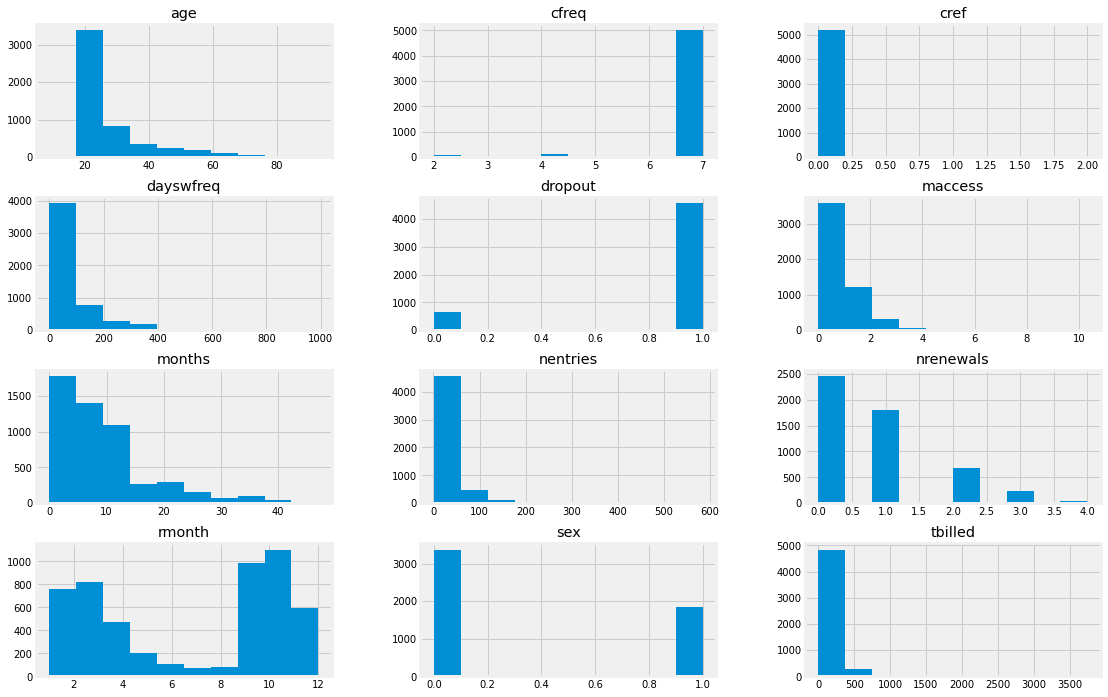

In [38]:
plt.rcParams['figure.figsize']=[17,12]
dt.hist();

# Dropout prediction

1. Some data preparation
2. Create dataset with features and prediction variable

In [39]:
X=dt.copy()
y=dt['dropout']
X.drop(axis=1,columns=['dropout'],inplace=True)

In [40]:
X.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'nentries', 'cfreq',
       'nrenewals', 'cref', 'months', 'rmonth'],
      dtype='object')

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5209 entries, 00130FE8-5D34-4C66-9819-1EB0BFE69979 to FFFB7214-F2FE-4AC0-8BD2-DB1CD47BDBEF
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        5209 non-null   int64  
 1   sex        5209 non-null   int64  
 2   dayswfreq  5209 non-null   int64  
 3   tbilled    5209 non-null   float64
 4   maccess    5209 non-null   float64
 5   nentries   5209 non-null   int64  
 6   cfreq      5209 non-null   float64
 7   nrenewals  5209 non-null   int64  
 8   cref       5209 non-null   int64  
 9   months     5209 non-null   int64  
 10  rmonth     5209 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 488.3+ KB


In [42]:
X.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'nentries', 'cfreq',
       'nrenewals', 'cref', 'months', 'rmonth'],
      dtype='object')

In [43]:
X.describe().round(decimals=2)

,age,sex,dayswfreq,tbilled,maccess,nentries,cfreq,nrenewals,cref,months,rmonth
count,5209.00,5209.00,5209.0,5209.00,5209.00,5209.00,5209.00,5209.00,5209.00,5209.00,5209.00
mean,27.89,0.35,76.4,155.32,0.89,29.06,6.86,0.78,0.01,9.35,6.72
std,11.80,0.48,101.8,162.45,0.76,41.15,0.72,0.90,0.08,8.22,3.53
min,9.00,0.00,0.0,3.60,0.01,1.00,2.00,0.00,0.00,0.00,1.00
25%,21.00,0.00,10.0,61.60,0.33,6.00,7.00,0.00,0.00,3.00,3.00
50%,23.00,0.00,41.0,102.60,0.68,15.00,7.00,1.00,0.00,7.00,9.00
75%,30.00,1.00,99.0,186.10,1.21,35.00,7.00,1.00,0.00,12.00,10.00
max,93.00,1.00,991.0,3747.20,10.33,585.00,7.00,4.00,2.00,47.00,12.00


In [44]:
y.describe().round(decimals=2)

count    5209.00
mean        0.88
std         0.33
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: dropout, dtype: float64

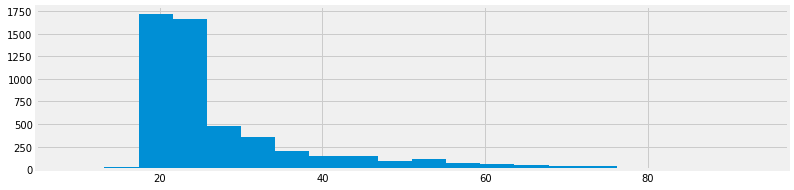

In [45]:
plt.rcParams['figure.figsize'] = [12, 3]
X.age.hist(bins=20)

In [46]:
X.sex.value_counts()

0    3376
1    1833
Name: sex, dtype: int64

## Comparison of the performance of the machine learning classifier

__Create train/test__
1. Part of the data (70%) was used to ‘train’ the model, and the other 30% to test the model (Buntine & Niblett, 1992). Was also possible the proportion 2/3 for training and 1/3 for test (Kohavi 1995;Gama et al. 2017)
2. To ensure the proportion of cases in the train/test the stratification was defined in the target variable
3. Altought the class weights were optimized with grid-search best results were achieved with balanced.

Balanced calculations are based in the following formula:

$K_n=\frac{n}{k.n_j}$
where:
- $n$ sample size
- $k$ number of classes
- $n_j$ observations in class j

More details available in scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
).

12% of the data are customers that didn't dropout. We are going to address this using grid search to tune this parameter Based on this example: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

In [47]:
# calculation class weights
n=len(y)
k=2
print(y.value_counts())
n0=np.bincount(y)[0]
n1=np.bincount(y)[1]
print('class 1 %2f class 2 %2f' % ((n/(2*n0)),(n/(k*n1))))

1    4565
0     644
Name: dropout, dtype: int64
class 1 4.044255 class 2 0.570537


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify = y, random_state=0)
print('Size X_train:',X_train.shape)
print('Size X_test:',X_test.shape)
print('Size y_train:',y_train.shape)
print('Size y_test:',y_test.shape)

Size X_train: (3646, 11)
Size X_test: (1563, 11)
Size y_train: (3646,)
Size y_test: (1563,)


### Confirm if the proportion of cases are maintained

In [49]:
print('base \t%s ratio %2f \ny_train %s ratio %2f \ny_test \t%s ratio %2f'
      % (np.bincount(y), np.bincount(y)[0]/(np.bincount(y)[0]+np.bincount(y)[1]),
         np.bincount(y_train),np.bincount(y)[0]/(np.bincount(y)[0]+np.bincount(y)[1]),
         np.bincount(y_test), np.bincount(y)[0]/(np.bincount(y)[0]+np.bincount(y)[1])))

base 	[ 644 4565] ratio 0.123632 
y_train [ 451 3195] ratio 0.123632 
y_test 	[ 193 1370] ratio 0.123632


### Model accuracies

#### Logistic Regression

In [50]:
# getting params that can be optimized in gridsearch
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [51]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [52]:
start_time = time.time()

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = LogisticRegression(random_state=42, class_weight={0: 4.0, 1: 0.571}),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
best AUC score: 0.845118956856046
execution time: 144.8417353630066


In [53]:
model_lr = LogisticRegression(C=1.0,penalty='l2', solver='liblinear' , random_state=42, class_weight={0: 4.0, 1: 0.571})
model_lr.fit(X_train,y_train)
y_pred_lr = model_lr.predict(X_test)
print(metrics.classification_report(y_test,y_pred_lr))
print(metrics.confusion_matrix(y_test,y_pred_lr))
#print("Features sorted by their score:") Logistic regression dont allow to sort features by their score
#print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model.feature_importances_), X_train.columns),reverse=True))
matrix_LR=metrics.confusion_matrix(y_test, y_pred_lr)
print('AUC',metrics.roc_auc_score(y_test, y_pred_lr))
print('AUC_ROC',roc_auc_ci(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.33      0.78      0.47       193
           1       0.96      0.78      0.86      1370

    accuracy                           0.78      1563
   macro avg       0.65      0.78      0.66      1563
weighted avg       0.88      0.78      0.81      1563

[[ 150   43]
 [ 302 1068]]
AUC 0.7783820581672402
AUC_ROC (0.7494756979060808, 0.8072884184283995)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Logistic regression**
1 = Positive/0 = negative

|  &nbsp; | &nbsp; |prev<br/>neg|<br/>pos | Tot   |
|---------|--------|:----------:|--------:|:-----:|
|true     | Neg    |  TN:169    |  FP:46  |   215 |
|  &nbsp; | Pos    |  FN:327    | TP:1195 |  1522 |
|         |        |    496     |  1241   |       |


In [54]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_lr).ravel()
print('tn:%d fp:%d fn:%d tp:%d' %(tn, fp, fn, tp))
print('accuracy %f sensitivy %f, specificity %f, precision %f, f1score %f' \
      %(((tp+tn)/(tp+tn+fn+fp)),(tp/(tp+fn)),tn/(tn+fp),tp/(tp+fp), 2*tp/(2*tp+fp+fn)))

tn:150 fp:43 fn:302 tp:1068
accuracy 0.779271 sensitivy 0.779562, specificity 0.777202, precision 0.961296, f1score 0.860943


#### DecisionTreeClassifier

In [55]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [56]:
max_features = ['auto', 'sqrt', 'log2','None']
max_depth = [3,4,5,6,7,8]
criterion = ['gini', 'entropy']
class_weight = ["balanced", "balanced_subsample"]

# define grid search
grid = dict(max_features=max_features,max_depth=max_depth, criterion=criterion, class_weight = class_weight)

In [57]:
start_time = time.time()

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto'}
best AUC score: 0.898652045224815
execution time: 2.9958386421203613


Class balanced is calculated using this formula $K_n=\frac{n}{k.n_j}$ so we mantain class_weight={0: 4.0, 1: 0.571}

In [58]:
model_dtc = DecisionTreeClassifier(class_weight={0: 4.0, 1: 0.571}, criterion='entropy',max_depth = 6, max_features='auto', random_state=42)
model_dtc.fit(X_train,y_train)
y_pred_dtc = model_dtc.predict(X_test)
print(metrics.classification_report(y_test,y_pred_dtc))
print(metrics.confusion_matrix(y_test,y_pred_dtc))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model_dtc.feature_importances_), X_train.columns),reverse=True))
matrix_DTC=metrics.confusion_matrix(y_test, y_pred_dtc)
print('AUCROC:',metrics.roc_auc_score(y_test, y_pred_dtc))
print('AUC_ROC_CI',roc_auc_ci(y_test,y_pred_dtc))

              precision    recall  f1-score   support

           0       0.47      0.81      0.60       193
           1       0.97      0.87      0.92      1370

    accuracy                           0.86      1563
   macro avg       0.72      0.84      0.76      1563
weighted avg       0.91      0.86      0.88      1563

[[ 157   36]
 [ 176 1194]]
Features sorted by their score:
[(0.52, 'dayswfreq'), (0.18, 'tbilled'), (0.16, 'months'), (0.06, 'nrenewals'), (0.03, 'age'), (0.02, 'rmonth'), (0.01, 'sex'), (0.01, 'nentries'), (0.01, 'maccess'), (0.0, 'cref'), (0.0, 'cfreq')]
AUCROC: 0.842502174653001
AUC_ROC_CI (0.8194738808408871, 0.8655304684651149)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Decision Tree Classifier**
1 = Positive/0 = negative

|  &nbsp; | &nbsp; |prev<br/>neg|<br/>pos | Tot   |
|---------|--------|:----------:|--------:|:-----:|
|true     | Neg    |  TN:176    |  FP:39  |   215 |
|  &nbsp; | Pos    |  FN:240    | TP:1282 |  1522 |
|         |        |    416     |  1321   |       |


In [59]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_dtc).ravel()
print('tn:%d fp:%d fn:%d tp:%d' %(tn, fp, fn, tp))
print('accuracy %f sensitivy %f, specificity %f, precision %f, f1score %f' \
      %(((tp+tn)/(tp+tn+fn+fp)),(tp/(tp+fn)),tn/(tn+fp),tp/(tp+fp), 2*tp/(2*tp+fp+fn)))

tn:157 fp:36 fn:176 tp:1194
accuracy 0.864363 sensitivy 0.871533, specificity 0.813472, precision 0.970732, f1score 0.918462


#### Random Forest Classifier

In [60]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [61]:
n_estimators = [100,200, 500]
max_features = ['auto', 'sqrt', 'log2','None']
max_depth = [4,5,6,7,8]
criterion = ['gini', 'entropy']
class_weight = ["balanced", "balanced_subsample"]

# define grid search
grid = dict(n_estimators = n_estimators,max_features=max_features,max_depth=max_depth, criterion=criterion, class_weight = class_weight)

In [62]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, stratify = y, random_state=0)

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = RandomForestClassifier(random_state=42),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
best AUC score: 0.9517397641853348
execution time: 794.111456155777


In [63]:
model_rfc = RandomForestClassifier(class_weight='balanced',criterion='gini',max_depth=8,max_features='auto',
                                   n_estimators=500, random_state=42)
model_rfc.fit(X_train,y_train)
y_pred_rfc = model_rfc.predict(X_test)
print(metrics.classification_report(y_test,y_pred_rfc))
print(metrics.confusion_matrix(y_test,y_pred_rfc))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model_rfc.feature_importances_), X_train.columns),reverse=True))
matrix_RFC=metrics.confusion_matrix(y_test, y_pred_rfc)
print('AUC',metrics.roc_auc_score(y_test, y_pred_rfc))
print('AUCROC:',metrics.roc_auc_score(y_test, y_pred_rfc))
print('AUC_ROC_CI',roc_auc_ci(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       215
           1       0.97      0.94      0.95      1522

    accuracy                           0.92      1737
   macro avg       0.81      0.86      0.83      1737
weighted avg       0.93      0.92      0.92      1737

[[ 170   45]
 [  93 1429]]
Features sorted by their score:
[(0.43, 'dayswfreq'), (0.14, 'months'), (0.1, 'tbilled'), (0.08, 'maccess'), (0.07, 'age'), (0.06, 'rmonth'), (0.06, 'nentries'), (0.05, 'nrenewals'), (0.01, 'sex'), (0.01, 'cfreq'), (0.0, 'cref')]
AUC 0.8647969318216544
AUCROC: 0.8647969318216544
AUC_ROC_CI (0.8451435573967021, 0.8844503062466067)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $ 
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Random Forest Classifier**

1 = Positive/0 = negative

|  &nbsp; | &nbsp; |prev<br/>neg|<br/>pos | Tot   |
|---------|--------|:----------:|--------:|:-----:|
|true     | Neg    |  TN:170    |  FP:45  |   215 |
|  &nbsp; | Pos    |  FN:93     | TP:1429 |  1522 |
|         |        |    263     |  1474   |       |


In [64]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_rfc).ravel()
print('tn:%d fp:%d fn:%d tp:%d' %(tn, fp, fn, tp))
print('accuracy %f sensitivy %f, specificity %f, precision %f, f1score %f' \
      %(((tp+tn)/(tp+tn+fn+fp)),(tp/(tp+fn)),tn/(tn+fp),tp/(tp+fp), 2*tp/(2*tp+fp+fn)))

tn:170 fp:45 fn:93 tp:1429
accuracy 0.920553 sensitivy 0.938896, specificity 0.790698, precision 0.969471, f1score 0.953939


#### Gradient Boosting Classifier

In [65]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [66]:
n_estimators = [100, 200, 500]
max_features = ['auto', 'sqrt', 'log2','None']
max_depth = [3,4,5,6,7,8]

# define grid search
grid = dict(n_estimators = n_estimators,max_features=max_features,max_depth=max_depth)

In [67]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, stratify = y, random_state=0)

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}
best AUC score: 0.965127764396604
execution time: 311.2577483654022


In [68]:
model_gbc = GradientBoostingClassifier(max_depth=6,max_features='sqrt',n_estimators=500, random_state=42)
model_gbc.fit(X_train,y_train)
y_pred_gbc = model_gbc.predict(X_test)
print(metrics.classification_report(y_test,y_pred_gbc))
print(metrics.confusion_matrix(y_test,y_pred_gbc))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model_gbc.feature_importances_), X_train.columns),reverse=True))
matrix_GBC=metrics.confusion_matrix(y_test, y_pred_gbc)
print('AUCROC:',metrics.roc_auc_score(y_test, y_pred_gbc))
print('AUC_ROC_CI',roc_auc_ci(y_test,y_pred_gbc))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       215
           1       0.96      0.99      0.97      1522

    accuracy                           0.96      1737
   macro avg       0.92      0.86      0.89      1737
weighted avg       0.95      0.96      0.95      1737

[[ 158   57]
 [  21 1501]]
Features sorted by their score:
[(0.35, 'dayswfreq'), (0.15, 'months'), (0.14, 'tbilled'), (0.07, 'rmonth'), (0.07, 'nentries'), (0.07, 'maccess'), (0.07, 'age'), (0.06, 'nrenewals'), (0.01, 'sex'), (0.01, 'cfreq'), (0.0, 'cref')]
AUCROC: 0.8605430431195183
AUC_ROC_CI (0.8404650542744497, 0.880621031964587)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $ 
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Gradient Boosting Classifier**

1 = Positive/0 = negative

|  &nbsp; | &nbsp; |prev<br/>neg|<br/>pos | Tot   |
|---------|--------|:----------:|--------:|:-----:|
|true     | Neg    |  TN:158    |  FP:57  |   215 |
|  &nbsp; | Pos    |  FN: 21    | TP:1501 |  1522 |
|         |        |    179     |  1558   |       |


In [69]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_gbc).ravel()
print('tn:%d fp:%d fn:%d tp:%d' %(tn, fp, fn, tp))
print('accuracy %f sensitivy %f, specificity %f, precision %f, f1score %f' \
      %(((tp+tn)/(tp+tn+fn+fp)),(tp/(tp+fn)),tn/(tn+fp),tp/(tp+fp), 2*tp/(2*tp+fp+fn)))

tn:158 fp:57 fn:21 tp:1501
accuracy 0.955095 sensitivy 0.986202, specificity 0.734884, precision 0.963415, f1score 0.974675


#### Neural Networks - Multi Layer Perceptron

In [71]:
MLPClassifier().get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [82]:
import itertools
[x for x in itertools.product((0.01,1,2),repeat=2)]

[(0.01, 0.01),
 (0.01, 1),
 (0.01, 2),
 (1, 0.01),
 (1, 1),
 (1, 2),
 (2, 0.01),
 (2, 1),
 (2, 2)]

In [87]:
solver = ['lbfgs', 'sgd', 'adam']
hidden_layer_sizes = np.arange(10,15)
# define grid search
grid = dict(solver = solver,hidden_layer_sizes=hidden_layer_sizes)

In [88]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, stratify = y, random_state=0)

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = MLPClassifier(random_state=42),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'hidden_layer_sizes': 12, 'solver': 'sgd'}
best AUC score: 0.8841644228915133
execution time: 29.012834787368774


In [91]:
model_mlp = MLPClassifier(hidden_layer_sizes=12, solver='sgd', random_state=42)
model_mlp.fit(X_train,y_train)
y_pred_mlp = model_mlp.predict(X_test)
print(metrics.classification_report(y_test,y_pred_mlp))
print(metrics.confusion_matrix(y_test,y_pred_mlp))
print("Features sorted by their score:")
#print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model_mlp.feature_importances_), X_train.columns),reverse=True))
matrix_MLP=metrics.confusion_matrix(y_test, y_pred_mlp)
print('AUCROC:',metrics.roc_auc_score(y_test, y_pred_mlp))
print('AUC_ROC_CI',roc_auc_ci(y_test,y_pred_mlp))

              precision    recall  f1-score   support

           0       0.66      0.46      0.54       215
           1       0.93      0.97      0.95      1522

    accuracy                           0.90      1737
   macro avg       0.79      0.71      0.74      1737
weighted avg       0.89      0.90      0.90      1737

[[  98  117]
 [  50 1472]]
Features sorted by their score:
AUCROC: 0.7114812211594291
AUC_ROC_CI (0.679270274526592, 0.7436921677922662)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $ 
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Gradient Boosting Classifier**

1 = Positive/0 = negative

|  &nbsp; | &nbsp; |prev<br/>neg|<br/>pos | Tot   |
|---------|--------|:----------:|--------:|:-----:|
|true     | Neg    |  TN:158    |  FP:57  |   215 |
|  &nbsp; | Pos    |  FN: 21    | TP:1501 |  1522 |
|         |        |    179     |  1558   |       |


In [92]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_mlp).ravel()
print('tn:%d fp:%d fn:%d tp:%d' %(tn, fp, fn, tp))
print('accuracy %f sensitivy %f, specificity %f, precision %f, f1score %f' \
      %(((tp+tn)/(tp+tn+fn+fp)),(tp/(tp+fn)),tn/(tn+fp),tp/(tp+fp), 2*tp/(2*tp+fp+fn)))

tn:98 fp:117 fn:50 tp:1472
accuracy 0.903857 sensitivy 0.967148, specificity 0.455814, precision 0.926369, f1score 0.946320


## Variable importance

Logistic Regression doesn't have feature importance. We are working in a classification problem with classes 0 and 1. The coefficients are  positive and negative, the positive represents a feature that predicts class 1,the negative scores a feature that predicts class 0.

In [ ]:
X_test.columns

In [ ]:
pd.DataFrame(list(zip(model_dtc.feature_importances_,X_test.columns)))

In [ ]:
pd.DataFrame(list(zip(model_rfc.feature_importances_,X_test.columns)))

In [ ]:
pd.DataFrame(list(zip(model_gbc.feature_importances_,X_test.columns)))

In [ ]:
importance = pd.DataFrame(dict(features=X_test.columns,lr=model_lr.coef_[0],
                               dtc=model_dtc.feature_importances_,
                               rfc=model_rfc.feature_importances_,
                               gbc=model_gbc.feature_importances_)).set_index('features')
importance=importance.sort_values(by='gbc',ascending=False)

In [ ]:
importance

In [ ]:
#fig,ax = plt.subplots(2,1,figsize=(15,7))
#ax1,ax2=ax.flatten()
#ax1.set_xticks([])
#ax1.set_ylabel('Relative importance')
#ax2.set_xticks([])
#ax2.set_ylabel('Coeficients')
##sns.distplot()
#importance[['dtc','rfc','gbc']].plot(kind='bar',title='Features importance',ax=ax1,xticks=[]).xaxis.label.set_visible(False);
#importance[['lr']].plot(kind='bar',ax=ax2);
importance[['dtc','rfc','gbc']].plot(kind='bar',title='Variables importance')
plt.legend(['Decision Tree Classifier','Random Forest Classifier','Gradient Boosting Classifier'])
plt.ylabel('Relative importance')
plt.xlabel('Features');


In [ ]:
plt.savefig(quality = 95, dpi = 'figure',fname = 'figure1.png')
plt.close()

## Trees visualization

In [ ]:
#model_tree = DecisionTreeClassifier(class_weight={0: 4.0, 1: 0.571}, criterion='entropy',max_depth = 4, max_features='auto', random_state=42)
model_tree = DecisionTreeClassifier(criterion='entropy',max_depth = 4, max_features='auto', random_state=42)
model_tree.fit(X_test,y_test);

In [ ]:
dot_data = StringIO()
export_graphviz(model_tree, out_file=dot_data, feature_names=X.columns, class_names=['0','1'],label='all',
                filled=False, rounded=True,
                special_characters=True,max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
#graph.write_png('trees/dtc1_arvore.png')
Image(graph.create_png())

In [ ]:
y_test.value_counts()

In [ ]:
model_tree = DecisionTreeClassifier(class_weight={0: 4.0, 1: 0.571}, criterion='entropy',max_depth = 3, max_features='auto', random_state=42)
model_tree.fit(X_test,y_test);

In [ ]:
viz = dtreeviz(model_tree,X_test,y_test,target_name='dropout',feature_names=X.columns,class_names=['no','yes'])

viz.view()
viz.save('trees/dtc2_arvore.svg')

In [ ]:
sub_tree_98 = model_gbc.estimators_[98, 0]

In [ ]:
viz = dtreeviz(sub_tree_98,X_train,y_train,target_name='dropout',feature_names=X.columns,class_names=['no','yes'],orientation='LR')

viz.view()
viz.save('trees/dtc2_arvore.svg')

In [ ]:
X_test.columns

In [ ]:
print(tree.export_text(model_dtc,decimals=1,max_depth=6,feature_names=['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'nentries', 'cfreq','nrenewals', 'cref', 'months', 'rmonth']))

In [ ]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(model_dtc,max_depth=3,feature_names=X_test.columns, class_names=['0','1'],filled=True);
fig.savefig('trees/dtree_dtc_arvore.png')